In [ ]:
# env: devitomod
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


## Geometry

In [ ]:
# parameters
inputfile = 'data/data_noise.npz'
inputdata = np.load(inputfile)

# Receivers
r = inputdata['r']
dr = r[0, 1]-r[0, 0]
nr = r.shape[1]

# Sources
s = inputdata['s']
ds = s[1, 1]-s[1, 0]
ns = s.shape[1]

# models
rho = inputdata['rho']
vel = inputdata['vel']

# Time axis
t = inputdata['t']
ot, dt, nt = t[0], t[1]-t[0], len(t)

# Axes
x, z = inputdata['x'], inputdata['z']
dx, dz = x[1] - x[0], z[1] - z[0]


In [ ]:
pup = inputdata['p'].transpose(1, 0, 2)
pup.shape

(401, 351, 2933)

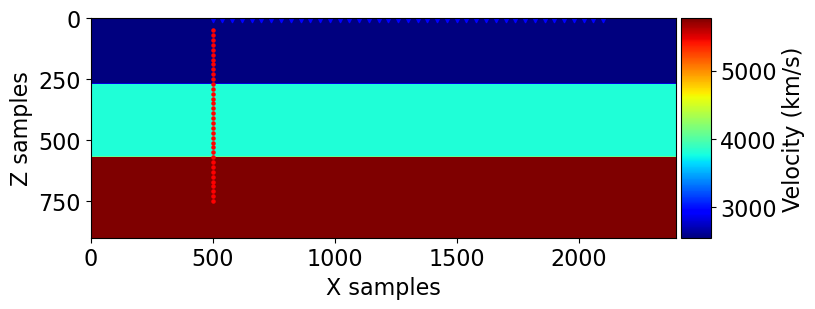

In [16]:
plt.figure(figsize=(8,8))
plot = plt.imshow(vel,cmap='jet',origin='upper',extent = (x[0], x[-1], z[-1], z[0]))
plt.xlabel("X samples")
plt.ylabel("Z samples")
plt.scatter(s[0, 0::10], s[1, 0::10], marker='o', s=5, c='r')
plt.scatter(r[0, 0::10],  r[1, 0::10], marker='v', s=20, c='b')
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(plot, cax=cax)
cbar.set_label('Velocity (km/s)')

plt.show()

In [ ]:
aligned_p_file = np.load('data/aligned_pnoise.npz')

In [ ]:
aligned_p = aligned_p_file['aligned_pup']
shift_p = aligned_p_file['shift_pup']


In [ ]:
stacking_data = np.zeros((ns, nt))
release_stacking = np.zeros((ns, nt, nr))
enegy_original = np.zeros((nr,))

for i in range(ns):
    stacking_data[i] = np.sum(aligned_p[i], axis=-1)

    for j in range(nr):
        enegy_original[j] = np.linalg.norm(aligned_p[i,:,j], ord=2)
    enegy_sum = np.sum(enegy_original)

    for j in range(nr):
        release_stacking[i, :, j] = (enegy_original[j]/enegy_sum)*stacking_data[i]

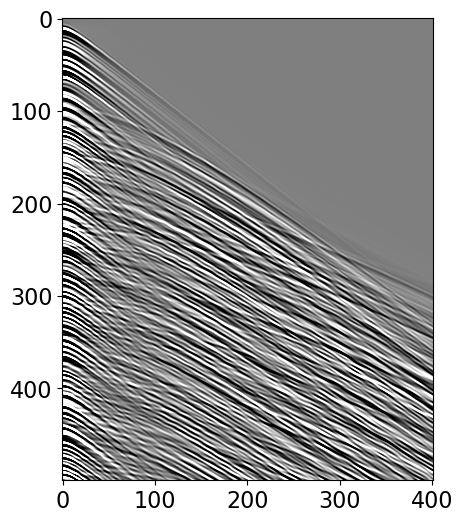

In [23]:
plt.imshow(pup[:,0,:500].T, cmap='gray', vmin=-0.1*np.max(pup), vmax=0.1*np.max(pup))

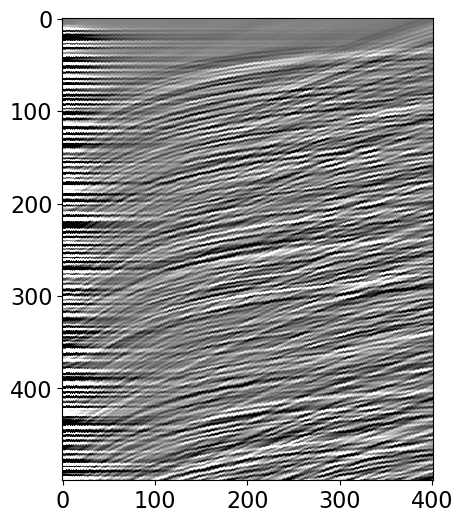

In [24]:
plt.imshow(aligned_p[0,:500], cmap='gray', vmin=-0.1*np.max(aligned_p), vmax=0.1*np.max(aligned_p))

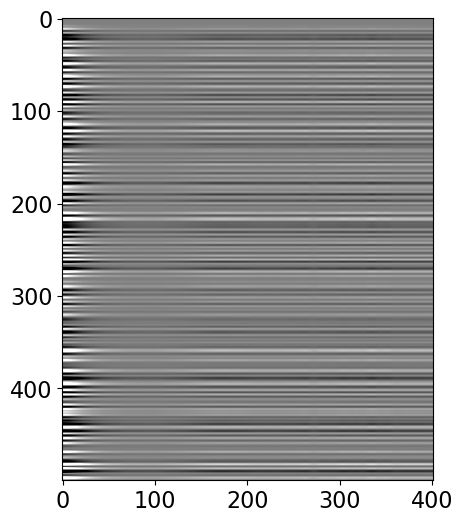

In [26]:
plt.imshow(release_stacking[0,:500], cmap='gray', vmin=-0.1*np.max(aligned_p), vmax=0.1*np.max(aligned_p))

In [ ]:
dir_restore = np.zeros_like(release_stacking)
for j in range(ns):
    for i in range(nr):
        if shift_p[j,i] == 0:
            dir_restore[j, :, i] = release_stacking[j, :, i]
        else:
            dir_restore[j, :, i] = np.concatenate((np.zeros(int(shift_p[j,i])), release_stacking[j, :-int(shift_p[j, i]), i]), axis=0 )

dir_restore = dir_restore/(dir_restore.max()/pup.max())            

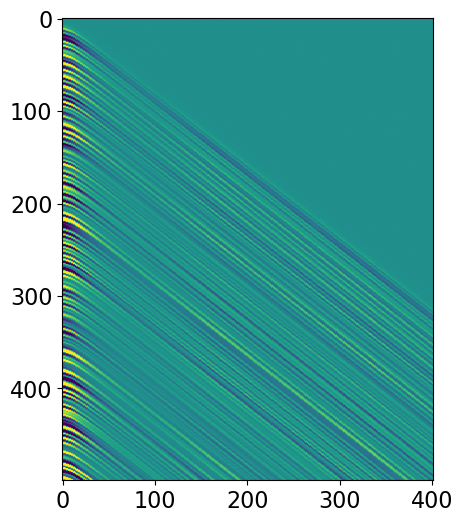

In [42]:
plt.imshow(dir_restore[0,:500], vmin=-0.1*np.max(aligned_p), vmax=0.1*np.max(aligned_p))

In [ ]:
np.savez('./data/pnoise_for_adp_sub.npz', dir_restore=dir_restore.transpose(0,2,1), pfull=pup.transpose(1,0,2), x=x, z=z, t=t, r=r, s=s, vel=vel, rho=rho)